In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from tqdm.auto import tqdm
from itertools import product

In [2]:
api = wandb.Api(timeout=60)

In [3]:
sweep_ids= ("jr53t2sc", "2nnw9t16", "3cxtmmnd", "utftyizc", "ajissigi", "ga50vfce", "rj4ec79v")
sweeps = [api.sweep(f"project-avengers/goon-test/sweeps/{sweep_id}") for sweep_id in sweep_ids]

In [4]:
results = []
for s in sweeps:
    runs = s.runs
    for r in tqdm(runs):
        if r.state == "finished":
            config = deepcopy(r.config)
            last_loss =[x for x in r.scan_history(min_step=config["num_steps"], keys=["loss"])]
            if len(last_loss)==1:
            # assert len(last_loss) == 1, f"{len(last_loss)=}"
                config["loss"] = last_loss[0]["loss"]
                results.append(config)
            else:
                print(f"Found run {r} with {r.state=} and {last_loss=} with {len(last_loss)=}!=1")

True
True
True
True
True
True
True
True
True
True


  0%|          | 0/312 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


  0%|          | 0/78 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


  0%|          | 0/312 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


  0%|          | 0/312 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


  0%|          | 0/313 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


  0%|          | 0/312 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


  0%|          | 0/312 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [5]:
results_df = pd.DataFrame(results)
results_df

,mup,mup_s,optim,d_model,n_layer,tracker,weights,col_name,datasets,head_dim,...,seq_length,vocab_size,world_size,learning_rate,tokenizer_path,report_interval,mup_base_d_model,use_torch_compile,mup_simple_scaling_impl,loss
0,True,1.000000,adamw,8192,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.000010,/datasets/tokenizers/llama3,64,256,False,False,6.963238
1,True,0.666666,adamw,8192,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.000010,/datasets/tokenizers/llama3,64,256,False,False,7.046012
2,True,0.333333,adamw,8192,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.000010,/datasets/tokenizers/llama3,64,256,False,False,7.099581
3,True,0.000000,adamw,8192,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.000010,/datasets/tokenizers/llama3,64,256,False,False,7.158104
4,True,1.000000,adamw,8192,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.000022,/datasets/tokenizers/llama3,64,256,False,False,6.264204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,True,0.000000,adamw,256,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.046416,/datasets/tokenizers/llama3,64,2048,False,False,5.790274
1947,True,1.000000,adamw,256,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.100000,/datasets/tokenizers/llama3,64,2048,False,False,5.68799
1948,True,0.666666,adamw,256,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.100000,/datasets/tokenizers/llama3,64,2048,False,False,5.430338
1949,True,0.333333,adamw,256,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.100000,/datasets/tokenizers/llama3,64,2048,False,False,5.366807


In [6]:
non_nan_results_df = results_df[results_df.loss != "NaN"]
print(f"Removed {len(results_df) - len(non_nan_results_df)} NaNs")

Removed 66 NaNs


In [7]:
non_nan_results_df

,mup,mup_s,optim,d_model,n_layer,tracker,weights,col_name,datasets,head_dim,...,seq_length,vocab_size,world_size,learning_rate,tokenizer_path,report_interval,mup_base_d_model,use_torch_compile,mup_simple_scaling_impl,loss
0,True,1.000000,adamw,8192,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.000010,/datasets/tokenizers/llama3,64,256,False,False,6.963238
1,True,0.666666,adamw,8192,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.000010,/datasets/tokenizers/llama3,64,256,False,False,7.046012
2,True,0.333333,adamw,8192,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.000010,/datasets/tokenizers/llama3,64,256,False,False,7.099581
3,True,0.000000,adamw,8192,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.000010,/datasets/tokenizers/llama3,64,256,False,False,7.158104
4,True,1.000000,adamw,8192,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.000022,/datasets/tokenizers/llama3,64,256,False,False,6.264204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,True,0.000000,adamw,256,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.046416,/datasets/tokenizers/llama3,64,2048,False,False,5.790274
1947,True,1.000000,adamw,256,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.100000,/datasets/tokenizers/llama3,64,2048,False,False,5.68799
1948,True,0.666666,adamw,256,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.100000,/datasets/tokenizers/llama3,64,2048,False,False,5.430338
1949,True,0.333333,adamw,256,4,wandb,1,contents,dataset=cc_en_head,128,...,512,128256,8,0.100000,/datasets/tokenizers/llama3,64,2048,False,False,5.366807


In [8]:
mup_df = non_nan_results_df[non_nan_results_df.mup]
non_mup_df = non_nan_results_df[~non_nan_results_df.mup]

# Sort the mup dict by mup data
mup_df_dict = {}
for (mup_s, mup_base_d_model) in product(mup_df.mup_s.unique(), mup_df.mup_base_d_model.unique()):
    mup_df_dict[(mup_s, mup_base_d_model)] = mup_df[(mup_df.mup_s == mup_s) & (mup_df.mup_base_d_model == mup_base_d_model)]

Text(0.5, 0.98, 'n_layer-4_seq_length-512_head_dim-128_num_steps-8192_batch_size-8_acc_steps-1_world_size-8_optim-adamw')

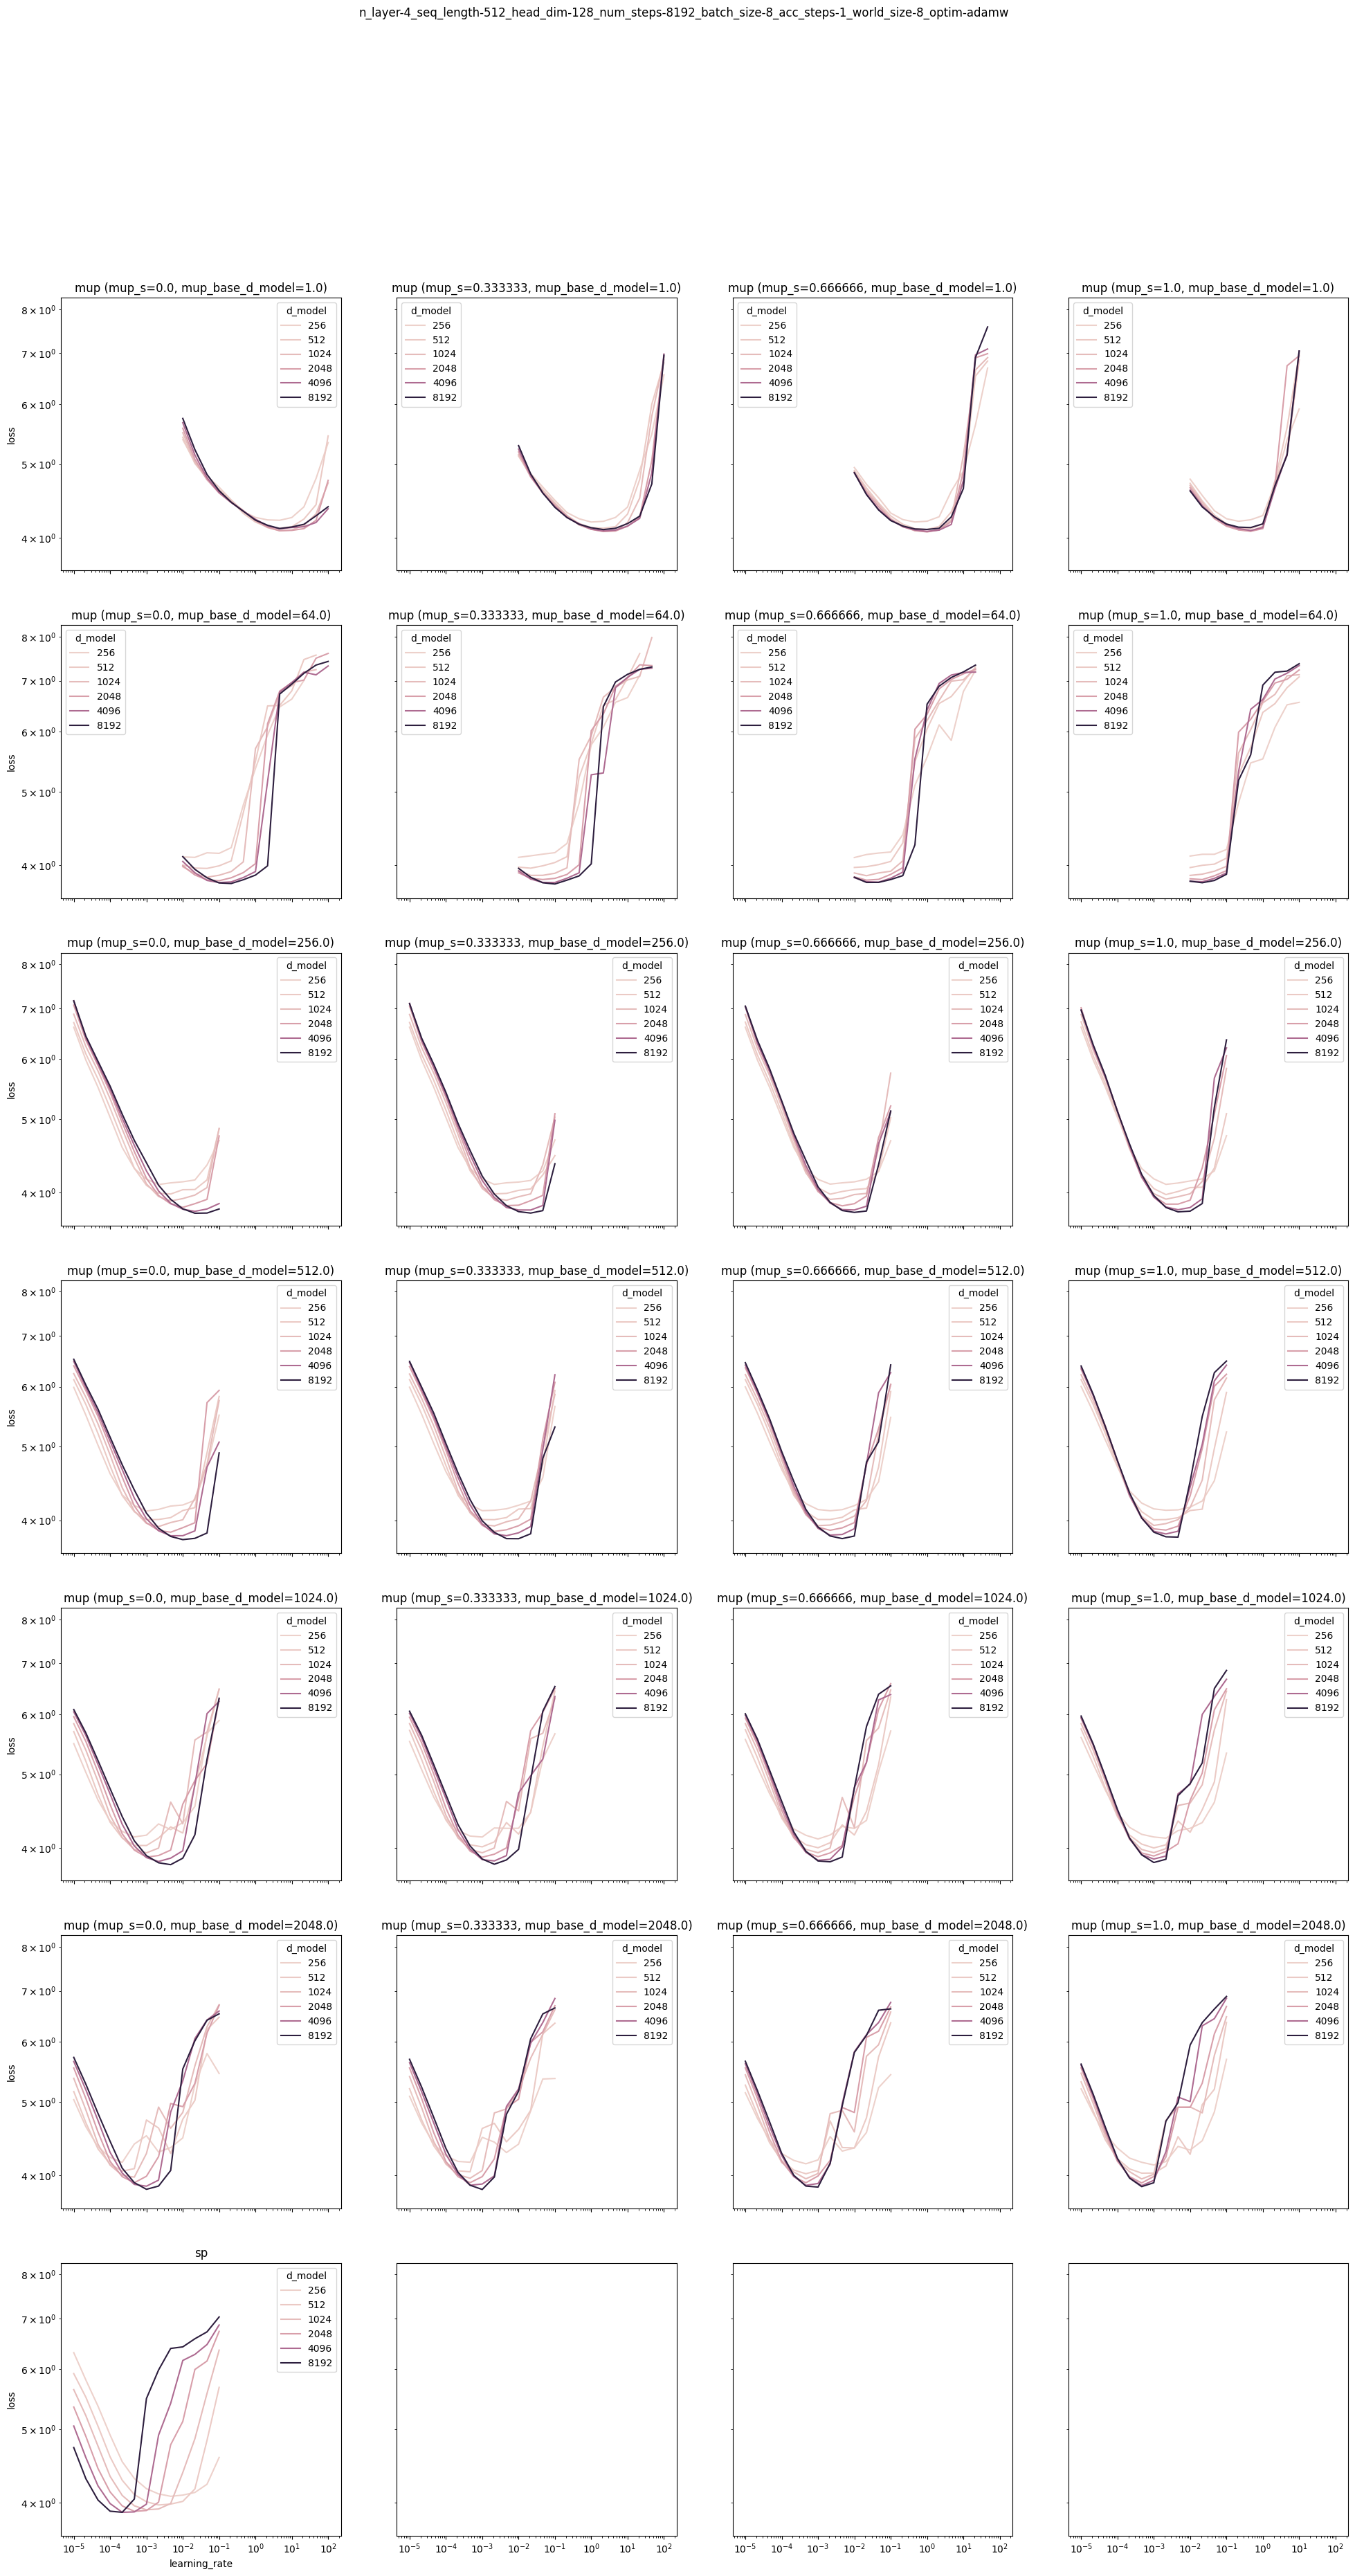

In [9]:
ncols = len(mup_df.mup_s.unique())
nrows = 1 + len(mup_df.mup_base_d_model.unique())
fig, axs = plt.subplots(                                                  
 ncols=ncols, nrows=nrows, sharey=True, sharex=True, figsize=(6 * ncols, 6 * nrows ) 
)                                                                         

no_mup_plot = sns.lineplot(data=non_mup_df, x="learning_rate", y="loss", hue="d_model", ax=axs[-1, 0])
axs[-1, 0].set_title("sp")
no_mup_plot.set(xscale="log")
no_mup_plot.set(yscale="log")

mup_s_to_col_dict = {mup_s: col for  col, mup_s in enumerate(sorted(mup_df.mup_s.unique()))}
mup_base_d_model_to_row_dict = {base_d_model: row for  row, base_d_model in enumerate(sorted(mup_df.mup_base_d_model.unique()))}

for (mup_s, mup_base_d_model), df in mup_df_dict.items():
    row = mup_base_d_model_to_row_dict[mup_base_d_model]
    col = mup_s_to_col_dict[mup_s]
    mup_plot = sns.lineplot(data=df, x="learning_rate", y="loss", hue="d_model", ax=axs[row, col])
    axs[row, col].set_title(f"mup (mup_s={float(mup_s)}, mup_base_d_model={float(mup_base_d_model)})")
    mup_plot.set(xscale="log")
    mup_plot.set(yscale="log")

suptitle = f'n_layer-{config.get("n_layer")}_seq_length-{config.get("seq_length")}_head_dim-{config.get("head_dim")}_num_steps-{config.get("num_steps")}_batch_size-{config.get("batch_size")}_acc_steps-{config.get("acc_steps",1)}_world_size-{config.get("world_size",1)}_optim-{config.get("optim")}'

fig.suptitle(suptitle)
#fig.subplots_adjust(top=0.8)
#fig.savefig(suptitle + ".png", dpi=256, bbox_inches="tight")

In [16]:
mup_df.groupby(["d_model",  "mup_base_d_model"]   ).loss.min()

d_model  mup_base_d_model
256      1                   4.194309
         64                  4.094171
         256                 4.100945
         512                 4.113976
         1024                4.108899
         2048                4.128642
512      1                   4.100267
         64                  3.961481
         256                 3.978078
         512                 4.006499
         1024                3.998895
         2048                4.020093
1024     1                   4.074647
         64                  3.857236
         256                 3.902251
         512                 3.924474
         1024                3.940074
         2048                3.957255
2048     1                   4.069971
         64                  3.816055
         256                 3.826578
         512                  3.85825
         1024                3.888075
         2048                3.909922
4096     1                   4.078029
         64             

In [11]:
import numpy as np
np.stack([mup_df.groupby("d_model").loss.min(),
non_mup_df.groupby("d_model").loss.min()])


array([[4.094171047210693, 3.9614810943603516, 3.8572356700897217,
        3.8160550594329834, 3.780740976333618, 3.75909423828125],
       [4.08164119720459, 3.9757134914398193, 3.9176716804504395,
        3.8999664783477783, 3.8883328437805176, 3.88811993598938]],
      dtype=object)